In [1]:
import numpy as np

import torch
import quairkit as qkit
from quairkit import to_state, Hamiltonian
from quairkit.database import *
from quairkit.qinfo import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qsp import *
from qite import *

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 17

In [4]:
qkit.set_dtype('complex128')
revise_tol(1e-40)

## Experiment setting

prepare Hamiltonian

In [5]:
num_qubits = 5

H_init = afm_heisenberg(n=num_qubits)
H = normalize(H_init, factor=np.abs(H_init.coefficients).sum())  # normalize the Hamiltonian

In [6]:
eigvals, eigvecs = torch.linalg.eigh(H.matrix)

ground_state_energy = eigvals[0].item()
first_excited_state_energy = eigvals[2].item()

print(f'ground state energy = {ground_state_energy}')
ground_state = to_state(eigvecs[:, 0])

ground state energy = -0.7319715633294984


Prepare input state that has state overlap $1/\sqrt{2}$ with the ground state.

In [7]:
coef_0, coef_rest = 1 / np.sqrt(2), 1 / np.sqrt(2 * (2 ** num_qubits - 1))
phi_state = to_state(coef_0 * eigvecs[:, 0] + coef_rest * eigvecs[:, 1:].sum(dim=1), system_dim=2 ** num_qubits)

gamma = torch.abs(phi_state.bra @ ground_state.ket).item()
print(f'The state overlap between input state and ground state is {gamma}')

The state overlap between input state and ground state is 0.707106781186547


Prepare ideal ITE state $\ket{\phi(\tau)}$ for $\tau = 20$

In [8]:
tau = 20
deg = 288

ite_op = torch.matrix_exp(-tau * H.matrix)
ideal_state = ite_op @ phi_state.ket
ideal_state = to_state(ideal_state / torch.linalg.norm(ideal_state))

Prepare evolution operator

In [9]:
U = torch.matrix_exp(-1j * H.matrix)

## Compute data

In [10]:
list_guess_lambda = np.linspace(-first_excited_state_energy - 0.1, -ground_state_energy + 1/tau + 0.1, 100)

list_fidelity, list_distance, list_probability = [], [], []

In [11]:
proj = nkron(zero_state(1).bra, eye(2 ** (num_qubits)))
input_state = nkron(zero_state(1), phi_state)

for guess_lambda in list_guess_lambda:
    list_theta, list_phi = qite.get_qpp_angle(guess_lambda=guess_lambda, tau=tau, deg=deg, learn=False)

    cir = qpp_cir(list_theta, list_phi, U)
    output_state = proj @ cir(input_state).ket
    state_norm = torch.linalg.norm(output_state).item()
    
    list_probability.append(state_norm**2)
    output_state = output_state / state_norm

    list_fidelity.append(state_fidelity(ideal_state, output_state))
    list_distance.append(trace_distance(ideal_state, output_state))
    
list_fidelity = np.clip(np.array(list_fidelity), a_min=0, a_max=1 - 1e-8)

## Plot

In [12]:
probability_lower_bound = 0.85**2 * np.exp(-2) * np.abs(gamma)**2

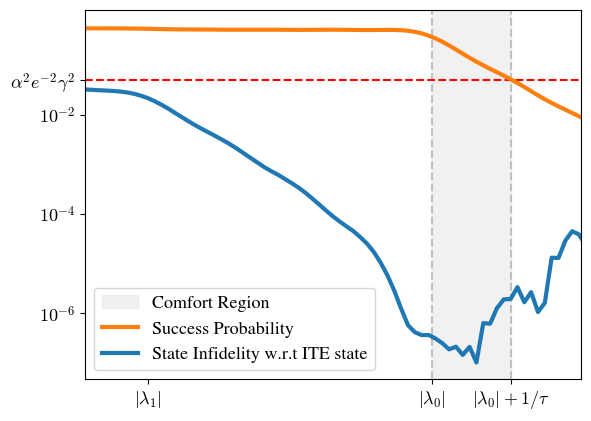

In [13]:
# plt.figure(figsize=(6,4))
plt.axvspan(xmin=-ground_state_energy, xmax=-ground_state_energy + 1 / tau, color='lightgrey', alpha=0.3,
            label='Comfort Region')
plt.axvline(x=-ground_state_energy, color='silver', linestyle='--')
plt.axvline(x=-ground_state_energy + 1 / tau, color='silver', linestyle='--')

plt.axhline(y=np.log10(probability_lower_bound), color='red', linestyle='--')

plt.plot(list_guess_lambda, np.log10(list_probability), label='Success Probability', color='C1', lw=3)
plt.plot(list_guess_lambda, np.log10(1 - list_fidelity), label='State Infidelity w.r.t ITE state', color='C0', lw=3)
# plt.plot(list_guess_lambda, np.log10(list_distance), label='Trace\nDistance', color='C0', lw=3)

plt.xticks([-first_excited_state_energy, -ground_state_energy, -ground_state_energy + 1 / tau], ['$|\lambda_1|$', '$|\lambda_0|$', '$|\lambda_0| + 1 / \\tau$'])
plt.yticks([np.log10(probability_lower_bound.item()), -2, -4, -6], 
           ['$\\alpha^2e^{-2}\gamma^2$', '$10^{-2}$', '$10^{-4}$', '$10^{-6}$'])
plt.tick_params(labelsize=13)

plt.xlim([-first_excited_state_energy - 0.04, -ground_state_energy + 1/tau + 0.045])
plt.legend(loc='lower left', fontsize=13)

plt.show()

---

In [14]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.3
torch: 2.8.0+cu128
torch cuda: 12.8
numpy: 2.3.3
scipy: 1.16.2
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.13.7
OS: Linux
OS version: #63-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 15 19:04:15 UTC 2025
---------DEVICE---------
CPU:  AMD EPYC 9654 96-Core Processor
GPU: (0) NVIDIA GeForce RTX 4090
     (0) NVIDIA GeForce RTX 4090
